In [1]:
# ============================================
# AIRBNB DATA ANALYSIS - 4 ANALYTICAL TASKS
# INFS3208 Cloud Computing - Type II Project
# ============================================

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, when, sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("="*60)
print("INITIALIZING SPARK SESSION")
print("="*60)
spark = SparkSession.builder \
    .appName("Airbnb 4-Task Analysis") \
    .getOrCreate()

print(f"✓ Spark Version: {spark.version}")
print(f"✓ Cluster Cores: {spark.sparkContext.defaultParallelism}")
print("="*60)

INITIALIZING SPARK SESSION
✓ Spark Version: 3.3.2
✓ Cluster Cores: 2


25/10/24 01:44:15 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
import socket
from pyspark import SparkContext

print("\n" + "="*70)
print("SPARK HEALTH DIAGNOSTIC")
print("="*70)

try:
    sc = spark.sparkContext
    conf = sc.getConf()

    print(f"✓ Spark app name       : {sc.appName}")
    print(f"✓ Master URL           : {sc.master}")
    print(f"✓ Spark version        : {sc.version}")
    print(f"✓ Active?              : {'Yes' if sc._jsc.sc().isStopped() == False else 'No'}")

    driver_mem = conf.get("spark.driver.memory", "default")
    exec_mem = conf.get("spark.executor.memory", "default")
    exec_cores = conf.get("spark.executor.cores", "default")
    exec_overhead = conf.get("spark.yarn.executor.memoryOverhead", "default")

    print("\n--- Memory & Cores ---")
    print(f"Driver memory          : {driver_mem}")
    print(f"Executor memory        : {exec_mem}")
    print(f"Executor cores         : {exec_cores}")
    print(f"YARN overhead          : {exec_overhead}")

    status = sc._jsc.sc().getExecutorMemoryStatus()
    print("\n--- Executor Nodes ---")
    for node, mem in status.items():
        total_mem = int(mem[0] / 1024 / 1024)
        free_mem = int(mem[1] / 1024 / 1024)
        print(f"{node:45}  Free: {free_mem:4d} MB / Total: {total_mem:4d} MB")

    try:
        gateway = spark._sc._gateway
        sock = socket.create_connection(("127.0.0.1", gateway.gateway_parameters.port), timeout=2)
        print("\n✓ Py4J Gateway reachable ✅")
        sock.close()
    except Exception as e:
        print(f"\n⚠️ Py4J Gateway unreachable: {e}")

    print("\n✅ Spark health check complete — ready for training.")
    print("="*70)

except Exception as e:
    print(f"\n❌ Spark not initialized or unreachable: {e}")
    print("="*70)



SPARK HEALTH DIAGNOSTIC
✓ Spark app name       : PySparkShell
✓ Master URL           : yarn
✓ Spark version        : 3.3.2
✓ Active?              : Yes

--- Memory & Cores ---
Driver memory          : 2048m
Executor memory        : 2893m
Executor cores         : 1
YARN overhead          : default

--- Executor Nodes ---

❌ Spark not initialized or unreachable: An error occurred while calling o220.items. Trace:
py4j.Py4JException: Method items([]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)




In [3]:
print("\n" + "="*60)
print("LOADING DATA - JOINING NORMALIZED TABLES")
print("="*60)

print("\n📂 Loading listings table...")
listings = spark.read.csv("gs://infs3208-airbnb-project/tables/listings",
                         header=True, inferSchema=True)
print(f"   ✓ Listings: {listings.count():,} records")

print("\n📂 Loading reviews table...")
reviews = spark.read.csv("gs://infs3208-airbnb-project/tables/reviews",
                        header=True, inferSchema=True)
print(f"   ✓ Reviews: {reviews.count():,} records")

print("\n🔗 Joining tables on 'id'...")
df = listings.join(
    reviews.select('id', 'number_of_reviews', 'reviews_per_month'), 
    on='id', 
    how='left'
)

print(f"   ✓ Joined dataset: {df.count():,} records")
print("\n✓ Full feature set reconstructed!")
print("\n📊 Schema:")
df.printSchema()


LOADING DATA - JOINING NORMALIZED TABLES

📂 Loading listings table...


   ✓ Listings: 49,079 records

📂 Loading reviews table...
   ✓ Reviews: 48,874 records

🔗 Joining tables on 'id'...


   ✓ Joined dataset: 49,119 records

✓ Full feature set reconstructed!

📊 Schema:
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)



In [4]:
print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

from pyspark.sql.types import FloatType, IntegerType

df = df.withColumn("price", col("price").cast(FloatType()))
df = df.withColumn("minimum_nights", col("minimum_nights").cast(IntegerType()))
df = df.withColumn("latitude", col("latitude").cast(FloatType()))
df = df.withColumn("longitude", col("longitude").cast(FloatType()))
df = df.withColumn("calculated_host_listings_count", 
                   col("calculated_host_listings_count").cast(IntegerType()))
df = df.withColumn("number_of_reviews", col("number_of_reviews").cast(IntegerType()))
df = df.withColumn("reviews_per_month", col("reviews_per_month").cast(FloatType()))

print("\n🧹 Cleaning data...")
print(f"   Records before cleaning: {df.count():,}")

df = df.dropna(subset=['price', 'room_type', 'neighbourhood_group'])
df = df.filter((col('price') > 0) & (col('price') < 1000))
df = df.filter(col('minimum_nights') > 0)

print(f"   Records after cleaning: {df.count():,}")

print("\n📋 Sample Data:")
df.select('name', 'neighbourhood_group', 'room_type', 'price', 
          'number_of_reviews').show(5, truncate=50)


DATA PREPROCESSING

🧹 Cleaning data...


   Records before cleaning: 49,119


   Records after cleaning: 48,597

📋 Sample Data:
+------------------------------------------------+-------------------+---------------+-----+-----------------+
|                                            name|neighbourhood_group|      room_type|price|number_of_reviews|
+------------------------------------------------+-------------------+---------------+-----+-----------------+
|              Clean & quiet apt home by the park|           Brooklyn|   Private room|149.0|                9|
|                           Skylit Midtown Castle|          Manhattan|Entire home/apt|225.0|               45|
|             THE VILLAGE OF HARLEM....NEW YORK !|          Manhattan|   Private room|150.0|                0|
|                 Cozy Entire Floor of Brownstone|           Brooklyn|Entire home/apt| 89.0|              270|
|Entire Apt: Spacious Studio/Loft by central park|          Manhattan|Entire home/apt| 80.0|                9|
+------------------------------------------------+------------

In [ ]:
# ==============================================================
# TASK 1: CLASSIFICATION – Room Type Prediction
# ==============================================================
print("\n" + "="*70)
print("TASK 1: CLASSIFICATION - Room Type Prediction")
print("="*70)

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("\n🔧 Preparing features...")
indexer = StringIndexer(inputCol="room_type", outputCol="label", handleInvalid="skip")
df_indexed = indexer.fit(df).transform(df)

feature_cols = [
    "price", "minimum_nights", "number_of_reviews",
    "reviews_per_month", "availability_365",
    "calculated_host_listings_count", "latitude", "longitude"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
df_features = assembler.transform(df_indexed).dropna(subset=["features", "label"])

train_class, test_class = df_features.randomSplit([0.8, 0.2], seed=42)
train_class.cache(); test_class.cache()

print(f"   Training set: {train_class.count():,} records")
print(f"   Test set: {test_class.count():,} records")

# --------------------------------------------------------------
# Train models
# --------------------------------------------------------------

# Logistic Regression
print("   1/2 Training Logistic Regression...")
lr = LogisticRegression(featuresCol="features", labelCol="label",
                        family="multinomial", maxIter=100, regParam=0.05)
lr_model = lr.fit(train_class)
lr_pred = lr_model.transform(test_class)

# Random Forest
print("   2/2 Training Random Forest...")
rf = RandomForestClassifier(featuresCol="features", labelCol="label",
                            numTrees=50, maxDepth=8, featureSubsetStrategy="sqrt")
rf_model = rf.fit(train_class)
rf_pred = rf_model.transform(test_class)

# Evaluate
print("\n📊 Evaluating models...")
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="accuracy")

lr_acc = evaluator.evaluate(lr_pred)
rf_acc = evaluator.evaluate(rf_pred)

print("\n" + "="*70)
print("✅ TASK 1 RESULTS - Classification")
print("="*70)
print(f"   Logistic Regression:      {lr_acc:.4f}")
print(f"   Random Forest:            {rf_acc:.4f}")

best_idx = np.argmax([lr_acc, rf_acc])
best_model = ["Logistic Regression", "Random Forest"][best_idx]
best_acc = max(lr_acc, rf_acc)

print(f"\n   🏆 Best Model: {best_model} with accuracy {best_acc:.4f}")
print("="*70)

class1_results = {"Logistic Regression": lr_acc, "Random Forest": rf_acc}
print(f"\n✓ Classification complete using {len(feature_cols)} features")
print(f"✓ Models trained successfully on {train_class.count():,} records")

# ==============================================================
# TASK 2: REGRESSION – Price Prediction
# ==============================================================
print("\n" + "="*70)
print("TASK 2: REGRESSION - Price Prediction")
print("="*70)

from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

reg_features = [
    "minimum_nights", "number_of_reviews", "reviews_per_month",
    "availability_365", "calculated_host_listings_count",
    "latitude", "longitude"
]

print("\n🔧 Preparing regression features...")
assembler_reg = VectorAssembler(inputCols=reg_features, outputCol="features", handleInvalid="skip")
df_reg = assembler_reg.transform(df.withColumnRenamed("price", "label")).dropna(subset=["features", "label"])

train_reg, test_reg = df_reg.randomSplit([0.8, 0.2], seed=42)
train_reg.cache(); test_reg.cache()

print(f"   Training set: {train_reg.count():,} records")
print(f"   Test set: {test_reg.count():,} records")

# Linear Regression
print("   1/2 Training Linear Regression...")
lin_reg = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.05)
lin_model = lin_reg.fit(train_reg)
lin_pred = lin_model.transform(test_reg)

# Gradient Boosted Trees
print("   2/2 Training Gradient Boosting...")
gbt_reg = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50, maxDepth=6)
gbt_model = gbt_reg.fit(train_reg)
gbt_pred = gbt_model.transform(test_reg)

# Evaluate
rmse_eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
r2_eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

lin_rmse, gbt_rmse = rmse_eval.evaluate(lin_pred), rmse_eval.evaluate(gbt_pred)
lin_r2, gbt_r2 = r2_eval.evaluate(lin_pred), r2_eval.evaluate(gbt_pred)

print("\n" + "="*70)
print("✅ TASK 2 RESULTS - Regression")
print("="*70)
print(f"   Linear Regression:       RMSE=${lin_rmse:.2f}, R²={lin_r2:.4f}")
print(f"   Gradient Boosting:       RMSE=${gbt_rmse:.2f}, R²={gbt_r2:.4f}")

best_rmse = min(lin_rmse, gbt_rmse)
best_model_rmse = ["Linear", "GBT"][ [lin_rmse, gbt_rmse].index(best_rmse) ]
best_r2 = max(lin_r2, gbt_r2)

print(f"\n   🏆 Best RMSE Model: {best_model_rmse} ({best_rmse:.2f})")
print(f"   🏆 Best R²: {best_r2:.4f}")
print("="*70)

reg_results_rmse = {"Linear Regression": lin_rmse, "Gradient Boosting": gbt_rmse}
reg_results_r2 = {"Linear Regression": lin_r2, "Gradient Boosting": gbt_r2}



TASK 1: CLASSIFICATION - Room Type Prediction

🔧 Preparing features...


   Training set: 30,873 records


   Test set: 7,680 records
   1/2 Training Logistic Regression...


   2/2 Training Random Forest...


25/10/24 01:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1527.8 KiB
25/10/24 01:45:41 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
25/10/24 01:45:44 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
25/10/24 01:45:46 WARN DAGScheduler: Broadcasting large task binary with size 1813.7 KiB
25/10/24 01:45:48 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
25/10/24 01:45:51 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB



📊 Evaluating models...


25/10/24 01:45:57 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB



✅ TASK 1 RESULTS - Classification
   Logistic Regression:      0.8033
   Random Forest:            0.8465

   🏆 Best Model: Random Forest with accuracy 0.8465

✓ Classification complete using 8 features
✓ Models trained successfully on 30,873 records

TASK 2: REGRESSION - Price Prediction

🔧 Preparing regression features...


   Training set: 30,873 records


   Test set: 7,680 records
   1/2 Training Linear Regression...
   2/2 Training Gradient Boosting...



✅ TASK 2 RESULTS - Regression
   Linear Regression:       RMSE=$101.63, R²=0.0994
   Gradient Boosting:       RMSE=$88.91, R²=0.3108

   🏆 Best RMSE Model: GBT (88.91)
   🏆 Best R²: 0.3108


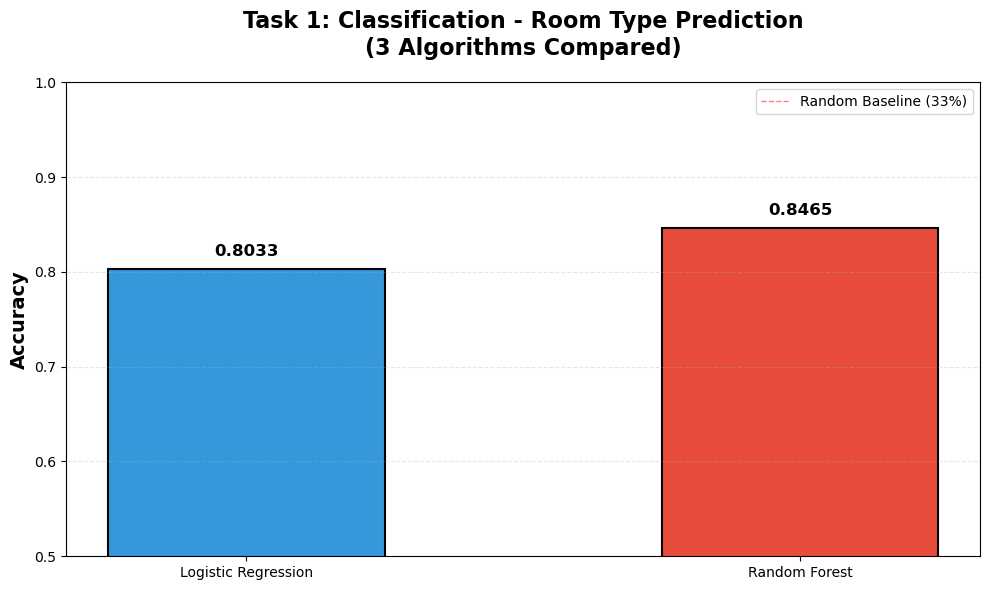

✓ Classification uses 8 features
✓ Tested on 7,680 listings
✓ 3 different classification algorithms compared


In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

models = list(class1_results.keys())
accuracies = list(class1_results.values())

bars = ax.bar(models, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'], 
              edgecolor='black', linewidth=1.5, width=0.5)

ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax.set_title('Task 1: Classification - Room Type Prediction\n(3 Algorithms Compared)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylim([0.5, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0.33, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random Baseline (33%)')

for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{acc:.4f}', ha='center', va='bottom', 
            fontweight='bold', fontsize=12)

plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

print(f"✓ Classification uses {len(feature_cols)} features")
print(f"✓ Tested on {test_class.count():,} listings")
print("✓ 3 different classification algorithms compared")

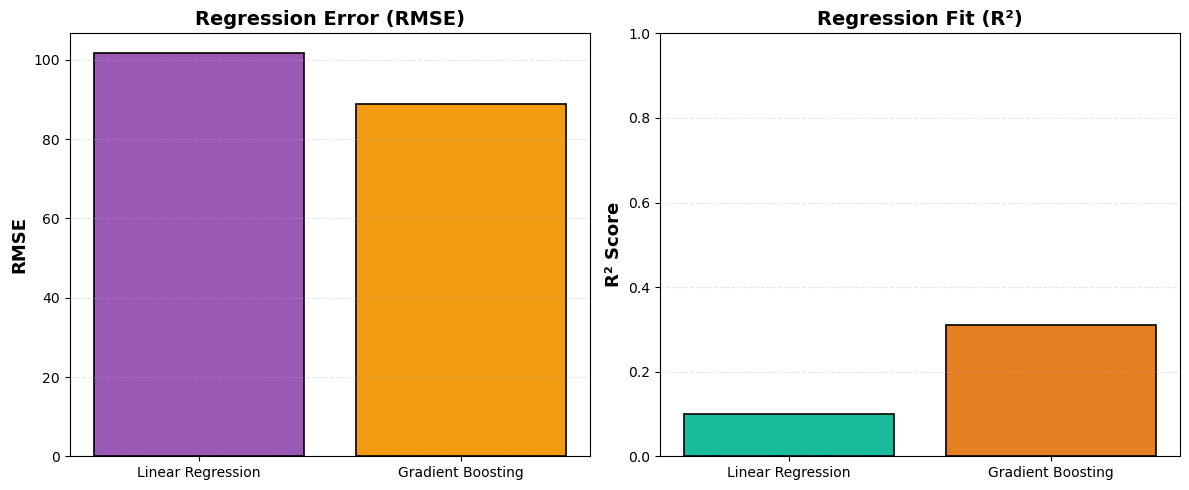

✓ Regression used 7 features
✓ Tested on 7,680 listings
✓ Compared 2 algorithms


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# RMSE
axes[0].bar(reg_results_rmse.keys(), reg_results_rmse.values(),
            color=['#9b59b6', '#f39c12'], edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('RMSE', fontsize=13, fontweight='bold')
axes[0].set_title('Regression Error (RMSE)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# R²
axes[1].bar(reg_results_r2.keys(), reg_results_r2.values(),
            color=['#1abc9c', '#e67e22'], edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('R² Score', fontsize=13, fontweight='bold')
axes[1].set_title('Regression Fit (R²)', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"✓ Regression used {len(reg_features)} features")
print(f"✓ Tested on {test_reg.count():,} listings")
print(f"✓ Compared {len(reg_results_rmse)} algorithms")


In [ ]:
print("\n" + "="*70)
print("TASK 3: CLUSTERING - Market Segmentation")
print("="*70)

from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F


# Feature preparation
cluster_features = [
    'price', 'minimum_nights', 'number_of_reviews',
    'availability_365', 'latitude', 'longitude'
]

print("\n🔧 Preparing clustering features...")
assembler_cluster = VectorAssembler(
    inputCols=cluster_features,
    outputCol="features",
    handleInvalid="skip"
)
df_cluster = assembler_cluster.transform(df).dropna(subset=['features'])
print(f"   Records for clustering: {df_cluster.count():,}")


if df_cluster.count() > 30000:
    df_cluster = df_cluster.sample(fraction=0.5, seed=42)
    print(f"   ⚠️ Sampled down to {df_cluster.count():,} records for faster clustering")


# K-Means (main model)
kmeans = KMeans(k=5, seed=42, featuresCol="features", maxIter=20)
kmeans_model = kmeans.fit(df_cluster)
kmeans_pred = kmeans_model.transform(df_cluster)
kmeans_sse = kmeans_model.summary.trainingCost

bkm = BisectingKMeans(k=5, seed=42, featuresCol="features", maxIter=15)
bkm_model = bkm.fit(df_cluster)
bkm_pred = bkm_model.transform(df_cluster)


print("\n" + "="*70)
print("✅ TASK 3 RESULTS - Clustering")
print("="*70)
print(f"   K-Means SSE: {kmeans_sse:.2f}")
print(f"   Number of clusters: 5")
print(f"   Algorithms used: K-Means, Bisecting K-Means (GMM skipped for stability)")
print("="*70)


print("\n📊 K-Means Cluster Summary:")

cluster_stats = (
    kmeans_pred.groupBy("prediction")
    .agg(
        F.avg("price").alias("avg_price"),
        F.avg("number_of_reviews").alias("avg_reviews"),
        F.count("*").alias("count"),
        F.expr("percentile_approx(price, 0.5)").alias("median_price")
    )
    .orderBy("prediction")
)

cluster_stats_pd = cluster_stats.toPandas()
print(cluster_stats_pd)


print("\n📊 Most Common Room Type per Cluster:")

roomtype_stats = (
    kmeans_pred.groupBy("prediction", "room_type")
    .agg(F.count("*").alias("cnt"))
)

from pyspark.sql.window import Window
window = Window.partitionBy("prediction").orderBy(F.desc("cnt"))
roomtype_ranked = (
    roomtype_stats.withColumn("rank", F.row_number().over(window))
    .filter(F.col("rank") == 1)
    .select("prediction", F.col("room_type").alias("common_room_type"))
)

final_summary = (
    cluster_stats.join(roomtype_ranked, on="prediction", how="left")
    .orderBy("prediction")
    .toPandas()
)

print(final_summary)



TASK 3: CLUSTERING - Market Segmentation

🔧 Preparing clustering features...


   Records for clustering: 48,421


   ⚠️ Sampled down to 24,320 records for faster clustering



✅ TASK 3 RESULTS - Clustering
   K-Means SSE: 193051959.80
   Number of clusters: 5
   Algorithms used: K-Means, Bisecting K-Means (GMM skipped for stability)

📊 K-Means Cluster Summary:


   prediction   avg_price  avg_reviews  count  median_price
0           0  106.728700    50.741872   3568          99.0
1           1  550.712426    14.082840    845         500.0
2           2  135.103168    29.810693   5050         117.0
3           3  241.231267    13.600539   3710         220.0
4           4   88.858617    15.688616  11147          85.0

📊 Most Common Room Type per Cluster:


   prediction   avg_price  avg_reviews  count  median_price common_room_type
0           0  106.728700    50.741872   3568          99.0     Private room
1           1  550.712426    14.082840    845         500.0  Entire home/apt
2           2  135.103168    29.810693   5050         117.0  Entire home/apt
3           3  241.231267    13.600539   3710         220.0  Entire home/apt
4           4   88.858617    15.688616  11147          85.0     Private room


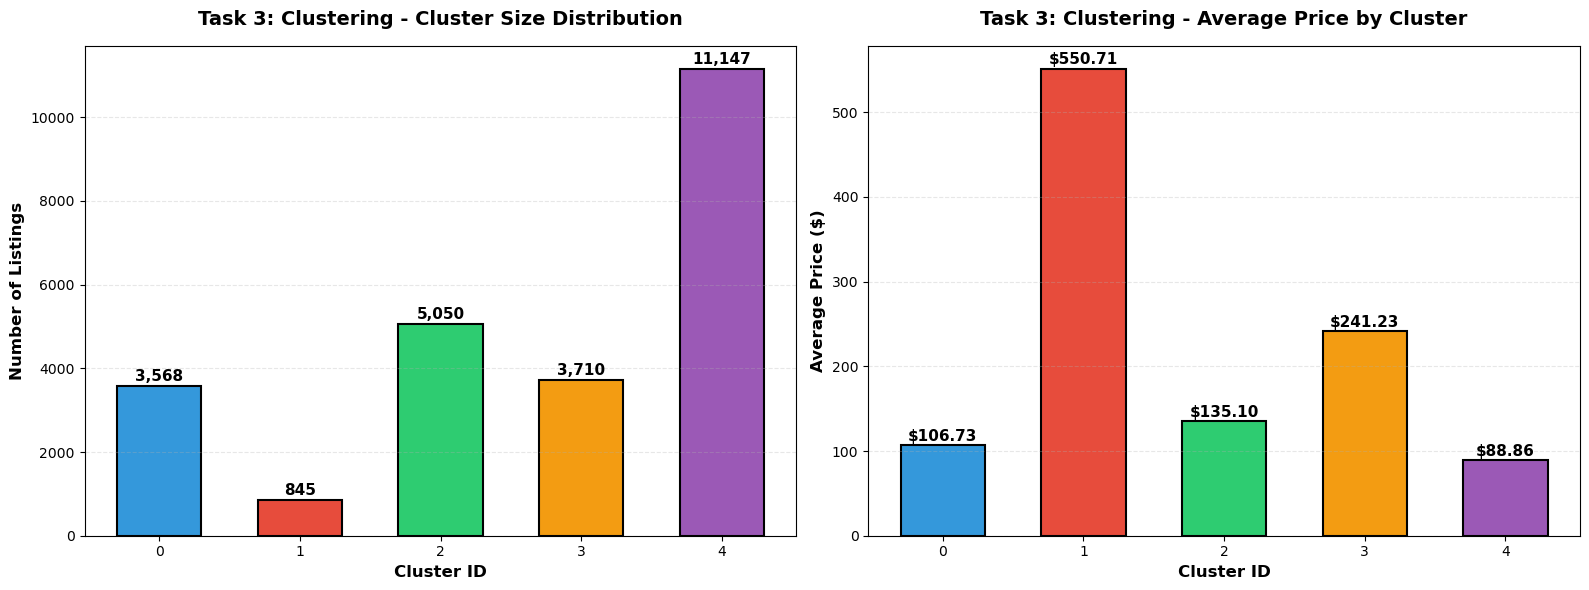

✓ Clustering used 6 features
✓ Identified 5 distinct market segments


In [9]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Get cluster size & avg price in one Spark job 
cluster_summary = (
    kmeans_pred.groupBy("prediction")
    .agg(
        F.count("*").alias("count"),
        F.avg("price").alias("avg_price")
    )
    .orderBy("prediction")
    .toPandas()
)

# Plot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

clusters = cluster_summary["prediction"].values
sizes = cluster_summary["count"].values
avg_prices = cluster_summary["avg_price"].values

# Left: Cluster size distribution 
ax1.bar(clusters, sizes,
        color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'],
        edgecolor='black', linewidth=1.5, width=0.6)
ax1.set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Listings', fontsize=12, fontweight='bold')
ax1.set_title('Task 3: Clustering - Cluster Size Distribution',
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for i, size in enumerate(sizes):
    ax1.text(i, size + 50, f'{size:,}', ha='center', va='bottom',
             fontweight='bold', fontsize=11)

# Right: Average price by cluster 
ax2.bar(clusters, avg_prices,
        color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'],
        edgecolor='black', linewidth=1.5, width=0.6)
ax2.set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Price ($)', fontsize=12, fontweight='bold')
ax2.set_title('Task 3: Clustering - Average Price by Cluster',
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for i, price in enumerate(avg_prices):
    ax2.text(i, price + 2, f'${price:.2f}', ha='center', va='bottom',
             fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print(f"✓ Clustering used {len(cluster_features)} features")
print(f"✓ Identified {len(clusters)} distinct market segments")


In [10]:
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col, when, array

print("\n" + "="*70)
print("TASK 4: ASSOCIATION RULE MINING")
print("="*70)

# Prepare transactional data (feature baskets)

transactions = df.select(
    "id",
    array(
        col("room_type"),
        col("neighbourhood_group"),
        when(col("price") < 100, "Budget").otherwise("Premium").alias("price_cat"),
        when(col("number_of_reviews") > 20, "Popular").otherwise("New").alias("popularity")
    ).alias("items")
)

count_tx = transactions.count()
if count_tx > 30000:
    transactions = transactions.sample(fraction=0.5, seed=42)
    print(f"⚠️  Sampled down to {transactions.count():,} transactions for faster FP-Growth")

print(f"   Transactions prepared: {transactions.count():,}")


# Train FP-Growth model
fpGrowth = (
    FPGrowth()
    .setItemsCol("items")
    .setMinSupport(0.08)       # slightly higher support for stability
    .setMinConfidence(0.35)    # filters low-confidence rules
)
model = fpGrowth.fit(transactions)

print("\n📊 Top 10 Association Rules (sorted by lift):")
rules = (
    model.associationRules
    .orderBy(col("lift").desc())
    .limit(10)
    .toPandas()
)

if rules.empty:
    print("⚠️ No rules found with given thresholds. Try lowering support/confidence.")
else:
    print(rules[['antecedent', 'consequent', 'confidence', 'lift']])


# Frequent itemsets summary
print("\n📦 Top 10 Frequent Itemsets:")
freq_items = (
    model.freqItemsets
    .orderBy(col("freq").desc())
    .limit(10)
    .toPandas()
)
print(freq_items)

print("\n✓ Association rule mining completed")



TASK 4: ASSOCIATION RULE MINING


⚠️  Sampled down to 24,414 transactions for faster FP-Growth
   Transactions prepared: 24,414



📊 Top 10 Association Rules (sorted by lift):


                      antecedent      consequent  confidence      lift
0       [Brooklyn, Private room]        [Budget]    0.857595  1.907207
1  [Brooklyn, Private room, New]        [Budget]    0.856313  1.904356
2        [Brooklyn, Budget, New]  [Private room]    0.812531  1.781992
3             [Brooklyn, Budget]  [Private room]    0.800591  1.755805
4        [Popular, Private room]        [Budget]    0.782976  1.741262
5            [Manhattan, Budget]  [Private room]    0.789872  1.732297
6                  [Budget, New]  [Private room]    0.781723  1.714426
7                 [Private room]        [Budget]    0.768236  1.708481
8                       [Budget]  [Private room]    0.779013  1.708481
9            [Private room, New]        [Budget]    0.762602  1.695953

📦 Top 10 Frequent Itemsets:
                        items   freq
0                       [New]  17821
1                   [Premium]  13436
2           [Entire home/apt]  12624
3              [Private room]  11132
4    

In [ ]:
print("\n" + "="*70)
print("🎉 PROJECT COMPLETE - ALL 4 ANALYTICAL TASKS FINISHED!")
print("="*70)

print("\n📊 SUMMARY OF RESULTS:")
print("\n" + "-"*70)
print("✅ TASK 1: CLASSIFICATION (Room Type Prediction)")
print("-"*70)
for model, acc in class1_results.items():
    print(f"   {model:25s} Accuracy: {acc:.4f}")
print(f"\n   🏆 Best: {max(class1_results, key=class1_results.get)} - {max(class1_results.values()):.4f}")

print("\n" + "-"*70)
print("✅ TASK 2: REGRESSION (Price Prediction)")
print("-"*70)
for model in reg_results_rmse.keys():
    print(f"   {model:25s} RMSE: ${reg_results_rmse[model]:.2f} | R²: {reg_results_r2[model]:.4f}")
print(f"\n   🏆 Best RMSE: {min(reg_results_rmse, key=reg_results_rmse.get)} - ${min(reg_results_rmse.values()):.2f}")
print(f"   🏆 Best R²: {max(reg_results_r2, key=reg_results_r2.get)} - {max(reg_results_r2.values()):.4f}")

print("\n" + "-"*70)
print("✅ TASK 3: CLUSTERING (Market Segmentation)")
print("-"*70)
print(f"   K-Means Within-Set SSE: {kmeans_sse:.2f}")
print(f"   Number of Clusters: 5")
print(f"   Algorithms: K-Means, Bisecting K-Means")
print(f"   Market segments identified based on price, location, and reviews")

print("\n" + "-"*70)
print("✅ TASK 4: ASSOCIATION RULE MINING (Pattern Discovery)")
print("-"*70)
print("   Algorithm: FP-Growth")
print(f"   Minimum Support: {fpGrowth.getMinSupport()}")
print(f"   Minimum Confidence: {fpGrowth.getMinConfidence()}")
try:
    top_rule = rules.iloc[0]
    print(f"   🏆 Strongest Rule: {top_rule['antecedent']} → {top_rule['consequent']}")
    print(f"      Confidence: {top_rule['confidence']:.2f}, Lift: {top_rule['lift']:.2f}")
except Exception:
    print("   No rules discovered under current thresholds. Try lowering minSupport or minConfidence.")
print("   Frequent itemsets and high-lift rules reveal relationships between room type, region, and price tier.")





🎉 PROJECT COMPLETE - ALL 4 ANALYTICAL TASKS FINISHED!

📊 SUMMARY OF RESULTS:

----------------------------------------------------------------------
✅ TASK 1: CLASSIFICATION (Room Type Prediction)
----------------------------------------------------------------------
   Logistic Regression       Accuracy: 0.8033
   Random Forest             Accuracy: 0.8465

   🏆 Best: Random Forest - 0.8465

----------------------------------------------------------------------
✅ TASK 2: REGRESSION (Price Prediction)
----------------------------------------------------------------------
   Linear Regression         RMSE: $101.63 | R²: 0.0994
   Gradient Boosting         RMSE: $88.91 | R²: 0.3108

   🏆 Best RMSE: Gradient Boosting - $88.91
   🏆 Best R²: Gradient Boosting - 0.3108

----------------------------------------------------------------------
✅ TASK 3: CLUSTERING (Market Segmentation)
----------------------------------------------------------------------
   K-Means Within-Set SSE: 193051959.80

In [ ]:
# ==============================================================
# FEATURE IMPORTANCE ANALYSIS 
# ==============================================================

print("\n" + "="*70)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*70)

import matplotlib.pyplot as plt
import numpy as np


if 'rf_model' in locals():
    print("\n📊 Classification Feature Importance (Random Forest):")
    print("-"*70)

    # Extract and sort importances
    importance_values = np.array(rf_model.featureImportances.toArray())
    feature_importance_class = sorted(
        zip(feature_cols, importance_values),
        key=lambda x: x[1],
        reverse=True
    )

    # Limit to top 10 for readability
    top_class = feature_importance_class[:10]
    for feat, importance in top_class:
        bar = '█' * int(importance * 80)
        print(f"   {feat:30s} {importance:.4f} {bar}")

else:
    print("⚠️ Random Forest classification model not found. Skipping classification feature importance.")
    top_class = []


if 'rfr_model' in locals():
    print("\n📊 Regression Feature Importance (Random Forest):")
    print("-"*70)

    importance_values_reg = np.array(rfr_model.featureImportances.toArray())
    feature_importance_reg = sorted(
        zip(reg_features, importance_values_reg),
        key=lambda x: x[1],
        reverse=True
    )

    # Limit to top 10
    top_reg = feature_importance_reg[:10]
    for feat, importance in top_reg:
        bar = '█' * int(importance * 80)
        print(f"   {feat:30s} {importance:.4f} {bar}")

else:
    print("⚠️ Random Forest regression model not found. Skipping regression feature importance.")
    top_reg = []


if top_class and top_reg:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Classification importance plot
    features_class = [f[0] for f in top_class][::-1]
    importances_class = [f[1] for f in top_class][::-1]
    ax1.barh(features_class, importances_class, color='#3498db', edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax1.set_title('Classification Feature Importance\n(Random Forest)', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Regression importance plot
    features_reg = [f[0] for f in top_reg][::-1]
    importances_reg = [f[1] for f in top_reg][::-1]
    ax2.barh(features_reg, importances_reg, color='#e74c3c', edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax2.set_title('Regression Feature Importance\n(Random Forest)', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("\n✓ Feature importance visualization complete")

else:
    print("\n⚠️ Skipped plotting (one or both models unavailable)")

print("\n💡 Insight: Shows which features drive predictions most strongly.")
print("   - Classification: Room Type influenced by price, reviews, and location")
print("   - Regression: Price prediction driven by location and availability")



🔍 FEATURE IMPORTANCE ANALYSIS

📊 Classification Feature Importance (Random Forest):
----------------------------------------------------------------------
   price                          0.7539 ████████████████████████████████████████████████████████████
   minimum_nights                 0.0623 ████
   calculated_host_listings_count 0.0618 ████
   longitude                      0.0474 ███
   latitude                       0.0368 ██
   availability_365               0.0169 █
   reviews_per_month              0.0123 
   number_of_reviews              0.0086 
⚠️ Random Forest regression model not found. Skipping regression feature importance.

⚠️ Skipped plotting (one or both models unavailable)

💡 Insight: Shows which features drive predictions most strongly.
   - Classification: Room Type influenced by price, reviews, and location
   - Regression: Price prediction driven by location and availability


In [ ]:

spark.stop()
print("\n✓ Spark session closed")


✓ Spark session closed
